In [48]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape
import os
import matplotlib.pyplot as plt

In [49]:
gpus = tf.config.list_physical_devices('GPU')

if len(gpus) > 0:
    print("TensorFlow is using the following GPU(s):")
    for gpu in gpus:
        print(f"- {gpu.name}")
else:
    print("No GPUs detected. TensorFlow is running on CPU.")

TensorFlow is using the following GPU(s):
- /physical_device:GPU:0


In [50]:
def load_file(board_file, labels_file):
    with open(board_file, 'r') as f:
        board = []
        for line in f:
            row = []
            for cell in line.strip().split(" "):
                if cell == '-':
                    row.append(9)
                elif cell == 'F':
                    row.append(-1)
                else:
                    try:
                        row.append(int(cell))
                    except ValueError:
                        continue
            board.append(row)

    board = np.array(board)

    labels = []
    with open(labels_file, 'r') as f:
        for line in f:
            row = []
            for cell in line.strip().split(" "):
                row.append(int(cell) + 1)
            labels.append(row)

    labels = np.array(labels)
    return board, labels

data_dir = "data 16x30"
labels_dir = "labels 16x30"
X = []
y = []

data_files = sorted(os.listdir(data_dir))
label_files = sorted(os.listdir(labels_dir))

if len(data_files) != len(label_files):
    raise ValueError("The number of data files does not match the number of label files.")

for data_file, label_file in zip(data_files, label_files):
    board, labels = load_file(f"{data_dir}\\{data_file}", f"{labels_dir}\\{label_file}")
    X.append(board)
    y.append(labels)

X = np.array(X)
y = np.array(y)
print(X[0])
print(y[0])

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 -1 -1  2 -1 -1  2  1  1  9
   9  9  9  9  9  9]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  3  3  4  3  3  3 -1  1  1  9
   9  9  9  9  9  9]
 [ 0  0  0  0  0  1  1  1  0  0  1  1  2 -1  3 -1  3 -1  1  1  1  2  2  9
   9  9  9  9  9  9]
 [ 0  1  1  2  1  2 -1  2  2  2  3 -1  3  2  3 -1  4  2  2  0  0  1 -1  3
   2  9  9  9  9  9]
 [ 0  1 -1  3 -1  3  3 -1  3 -1 -1  3 -1  2  2  3  3 -1  1  0  0  2  2  4
  -1  9  9  9  9  9]
 [ 1  2  2  4 -1  2  2 -1  3  2  2  3  2  3 -1  2 -1  2  1  0  0  1 -1  4
  -1  4  2  9  9  9]
 [ 9  9  9  9  3  2  2  1  1  0  0  1 -1  2  1  2  1  2  1  1  0  1  1  3
  -1  3  3  9  9  9]
 [ 9  9  9  9  2 -1  2  1  2  1  1  2  2  2  0  0  0  2 -1  4  2  1  0  1
   2  3 -1 -1  9  9]
 [ 9  9  9  9  9  2  3 -1  3 -1  1  1 -1  1  0  1  1  3 -1 -1 -1  2  0  0
   1 -1  4 -1  9  9]
 [ 9  9  9  9  9  1  2 -1  3  2  2  2  2  2  1  2 -1  3  4 -1 -1  3  1  0
   1  1  2  3  9  9]
 [ 9  9  9  9  9  2  3  2  2  1 -1  1  2 -1  3  4 

In [51]:
X_reshaped = []
for board in X:
    board_reshaped = board.reshape(board.shape[0], board.shape[1], 1)
    X_reshaped.append(board_reshaped)
    
X_reshaped = np.array(X_reshaped)

y_reshaped = []

for labels in y:
    labels_reshaped = labels.reshape(labels.shape[0], labels.shape[1], 1)
    y_reshaped.append(labels_reshaped)

y_reshaped = np.array(y_reshaped)

X, y = X_reshaped, y_reshaped
input_shape = (X.shape[1], X.shape[2], X.shape[3])
print(X.shape, y.shape)

(998, 16, 30, 1) (998, 16, 30, 1)


In [61]:
model = Sequential()

model.add(Flatten(input_shape=input_shape))

model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dense(input_shape[0] * input_shape[1], activation='sigmoid'))

model.add(Reshape((input_shape[0], input_shape[1])))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

# model.summary()

In [62]:
model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
25/25 [==============================] - 0s 8ms/step - loss: -10.3194 - binary_accuracy: 0.1557 - val_loss: -15.2220 - val_binary_accuracy: 0.1478
Epoch 2/10
25/25 [==============================] - 0s 4ms/step - loss: -15.2783 - binary_accuracy: 0.1496 - val_loss: -15.3309 - val_binary_accuracy: 0.1475
Epoch 3/10
25/25 [==============================] - 0s 3ms/step - loss: -15.3107 - binary_accuracy: 0.1495 - val_loss: -15.3309 - val_binary_accuracy: 0.1475
Epoch 4/10
25/25 [==============================] - 0s 3ms/step - loss: -15.3107 - binary_accuracy: 0.1495 - val_loss: -15.3309 - val_binary_accuracy: 0.1475
Epoch 5/10
25/25 [==============================] - 0s 3ms/step - loss: -15.3107 - binary_accuracy: 0.1495 - val_loss: -15.3309 - val_binary_accuracy: 0.1475
Epoch 6/10
25/25 [==============================] - 0s 3ms/step - loss: -15.3107 - binary_accuracy: 0.1495 - val_loss: -15.3309 - val_binary_accuracy: 0.1475
Epoch 7/10
25/25 [==============================] - 

1/1 [==============================] - 0s 53ms/step


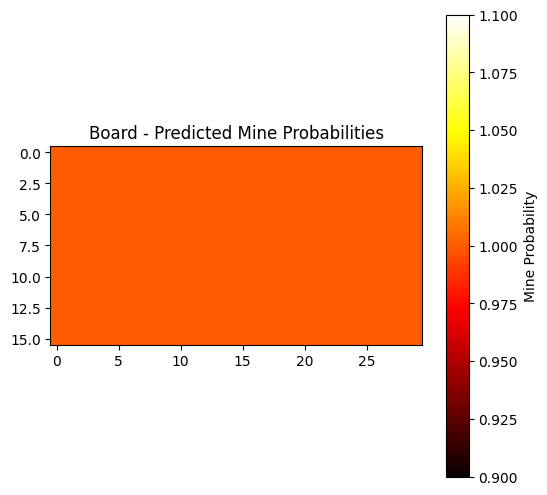

In [54]:
def test_model_on_board(model, board):
    board = np.expand_dims(board, axis=0)
    prediction = model.predict(board)
    predicted_probabilities = prediction[0]
    
    plt.figure(figsize=(6, 6))
    plt.title(f"Board - Predicted Mine Probabilities")
    plt.imshow(predicted_probabilities, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Mine Probability')
    plt.show()

test_model_on_board(model, X[0])